In [5]:
import numpy as np
from scipy.special import erf
from scipy.optimize import least_squares

def error_func(x, A, mu, sigma, C):
    # A/2 * (1 + erf((x - mu)/(sqrt(2)*sigma))) + C
    return A * 0.5 * (1.0 + erf((x - mu) / (np.sqrt(2) * sigma))) + C

def _finite_xy(x, y):
    x = np.asarray(x, float).ravel()
    y = np.asarray(y, float).ravel()
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m]

def _initial_guess(x, y):
    # Robust amplitude and offset from percentiles
    y_lo = np.percentile(y, 10)
    y_hi = np.percentile(y, 90)
    A_guess = y_hi - y_lo
    if abs(A_guess) < 1e-12:
        A_guess = (np.max(y) - np.min(y)) or 1.0
    C_guess = y_lo

    # Midpoint target and mu guess
    y_mid = C_guess + 0.5 * A_guess
    mu_guess = x[np.argmin(np.abs(y - y_mid))]

    # Sigma guess from 16–84% width (≈2σ)
    y_16 = C_guess + 0.158655 * A_guess
    y_84 = C_guess + 0.841345 * A_guess
    # nearest x at those levels
    x16 = x[np.argmin(np.abs(y - y_16))]
    x84 = x[np.argmin(np.abs(y - y_84))]
    width = abs(x84 - x16)
    sigma_guess = max(width / 2.0, (np.max(x) - np.min(x)) / 20.0, 1e-6)

    return np.array([A_guess, mu_guess, sigma_guess, C_guess], float)

def fit_error_func_safe(x, y, p0=None):
    """
    Robust fit of an error-function step ignoring NaNs/Infs.

    Returns
    -------
    popt : (A, mu, sigma, C)
    pcov : covariance (approx.; None if unavailable)
    info : dict with diagnostics
    """
    x, y = _finite_xy(x, y)
    if x.size < 4:
        raise ValueError("Not enough finite data points to fit.")

    if p0 is None:
        p0 = _initial_guess(x, y)

    # bounds: sigma > 0, mu within data range
    xmin, xmax = np.min(x), np.max(x)
    lower = np.array([-np.inf, xmin, 1e-9, -np.inf], float)
    upper = np.array([ np.inf, xmax, (xmax - xmin),  np.inf], float)

    def resid(theta):
        A, mu, sigma, C = theta
        return error_func(x, A, mu, sigma, C) - y

    res = least_squares(
        resid, p0, bounds=(lower, upper), loss="soft_l1", f_scale=1.0, max_nfev=2000
    )

    popt = res.x

    # Approximate covariance from Jacobian at solution (if full rank)
    pcov = None
    if res.jac is not None and res.jac.shape[0] >= res.jac.shape[1]:
        JTJ = res.jac.T @ res.jac
        try:
            pcov = np.linalg.inv(JTJ) * np.sum(res.fun**2) / max(len(y) - len(popt), 1)
        except np.linalg.LinAlgError:
            pcov = None

    info = {
        "success": res.success,
        "message": res.message,
        "nfev": res.nfev,
        "cost": res.cost,
        "initial_guess": p0,
        "bounds": (lower, upper),
    }
    return popt, pcov, info


Fit parameters: [-0.99458613  0.01113558  0.54889956  0.09376984]


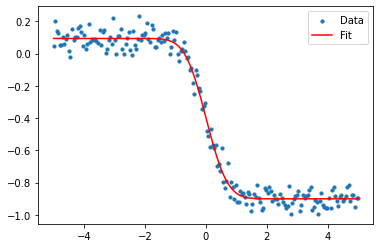

In [8]:
import matplotlib.pyplot as plt

# Generate synthetic data
x = np.linspace(-5, 5, 200)
y_true = error_func(x, A=-1.0, mu=0.0, sigma=0.5, C=0.1)
y_noisy = y_true + 0.05 * np.random.randn(len(x))

# Fit
popt, pcov, info = fit_error_func_safe(x, y_noisy)
A, mu, sigma, C = popt
# model = error_func(x, *popt)
print("Fit parameters:", popt)

# Plot
plt.scatter(x, y_noisy, s=10, label="Data")
plt.plot(x, error_func(x, *popt), 'r-', label="Fit")
plt.legend()
plt.show()
